# Covariate shift detection and correction example

Demo for the DIPA Data61 Course: Model Validation, Uncertainty and Missing Data

Dependencies:

- numpy
- scipy
- jupyter
- matplotlib
- scikit learn


In [55]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
#from sklearn.linear_model import LogisticRegression as LR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, log_loss
from IPython.display import display, HTML

%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})
np.random.seed(666)  # fix random seed
FIGSIZE = (16, 9)

## Generate data

Let's keep going with the cancer diagnosis problem, imagine the blue points are the positive cancer diagnosis.
10% of the sample have cancer, 90% do not. Let's generate two imaginary features, $\mathbf{x}$, that are somewhat predictive of a cancer diagnosis, $y \in \{0, 1\}$ (0 no cancer, 1 cancer).

The catch this time, is that our **training/validation** and **query** data come from two different populations!

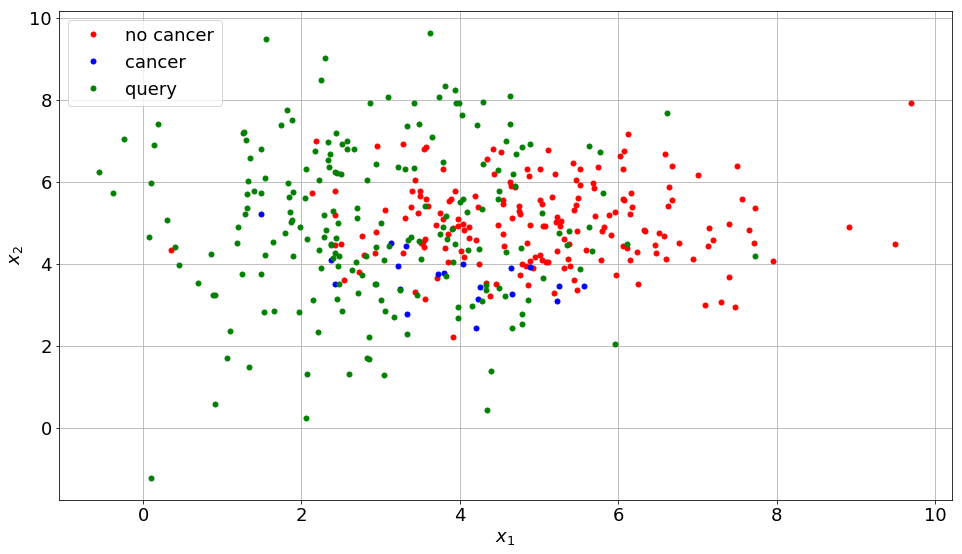

In [56]:
# class 1
n1 = 180 
mean1 = [5, 5]
cov1 = [
    [2.0, -0.1],
    [-0.1,  1.0]
]

X1 = np.random.multivariate_normal(mean1, cov1, n1)
Y1 = np.zeros(n1)

# class 2
n2 = 20
mean2 = [4, 3.7]
cov2 = [
    [1.0, -0.3],
    [-0.3,  0.5]
]

X2 = np.random.multivariate_normal(mean2, cov2, n2)
Y2 = np.ones(n2)

# Query data (unknown class)
nq = 200
meanq = [3., 5.]
covq = [
    [2.0, 0.],
    [0.,  4.0]
]

Xq = np.random.multivariate_normal(meanq, covq, nq)
Zq = np.zeros(nq)

# Mix them together
Xt = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))
Zt = np.ones(n2 + n1)

Xall = np.vstack((Xt, Xq))
Zall = np.concatenate((Zt, Zq))


# Plot
def plot_data():
    pl.plot(*X1.T, 'r.', label='no cancer', markersize=10)
    pl.plot(*X2.T, 'b.', label='cancer', markersize=10)
    pl.plot(*Xq.T, 'g.', label='query', markersize=10)
    pl.xlabel('$x_1$')
    pl.ylabel('$x_2$')
    pl.legend()
    pl.show()

pl.figure(figsize=FIGSIZE)
pl.grid()
plot_data()

# Detecting covariate shift
Lets first look at how we detect covariate shift... firstly, and more easily, if **we already have the query data**

## When you have the query data
This is much fairly straight forward, and a *conservative* way is to see if you can train a classifier to discriminate between the training and query data! For this we will use a Gaussian Process, because:
- It is non-linear
- It has well-calibrate probabilities (more about this later)

As always - you should use cross validation!!

In [57]:
# Helper function for scoring the prediction results
def score_result(y_test, y_bar, name, p=None):
    n = sum(y_test == 0)
    fp = sum(y_bar[y_test == 0])
    rdict = {
        "Accuracy": accuracy_score(y_test, y_bar),
        "FPR": fp / n,
        "Precision": precision_score(y_test, y_bar),
        "Recall (TPR)": recall_score(y_test, y_bar),
        "Log loss": np.nan
    }
    
    if p is not None:
        rdict["Log loss"] = log_loss(y_test, p)

    res = pd.DataFrame(rdict, index=[name])
    return res

# plot the probability contours of the classifier
def plot_contour(clf, x):
    xmin, xmax = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    ymin, ymax = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax.max():.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    contour = pl.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1, alpha=0.5)
    ax_c = pl.colorbar(contour)
    ax_c.set_label("$p(y = 1 | \mathbf{x})$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

In [58]:
# Split the data
X_train, X_test, z_train, z_test = train_test_split(
    Xall, Zall,
    test_size=0.2,
    stratify=Zall  # Note this!
)
    
# Set up the GP
kern = RBF()
gpc = GaussianProcessClassifier(kernel=kern)

# Train and test the GP
gpc.fit(X_train, z_train)
z_bar = gpc.predict(X_test)
pz = gpc.predict_proba(X_test)[:, 1]

res = score_result(z_test, z_bar, "Gaussian Process", pz)
display(HTML(res.to_html()))

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Gaussian Process,0.775,0.2,0.491864,0.789474,0.75


It looks like we can discriminate fairly well here... so this may be evidence of covariate shift in our data! Let's plot the probability contours of our classifier...

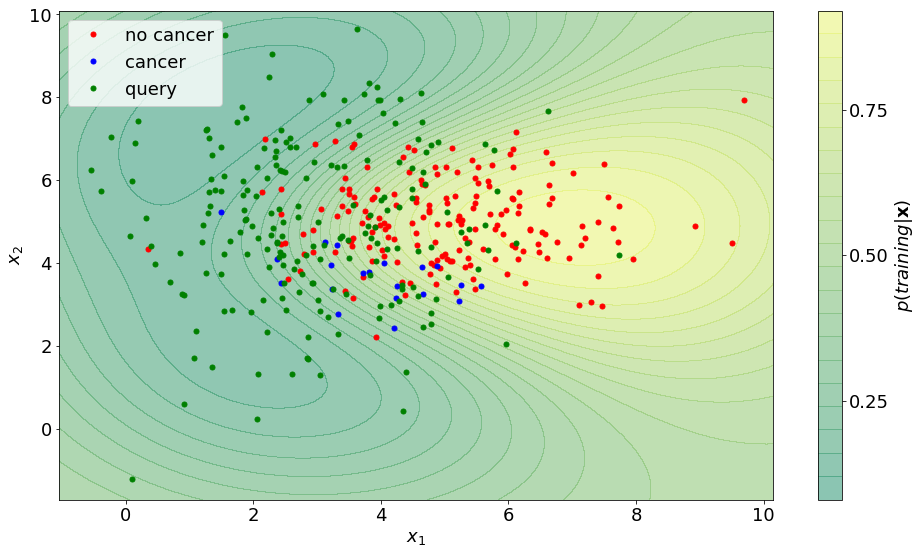

In [59]:
# plot the probability contours of the classifier
def plot_contour(clf, x):
    xmin, xmax = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    ymin, ymax = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax.max():.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    contour = pl.contourf(xx, yy, probs, 25, cmap="summer", vmin=0, vmax=1, alpha=0.5)
    ax_c = pl.colorbar(contour)
    ax_c.set_label("$p(training | \mathbf{x})$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

pl.figure(figsize=FIGSIZE)
plot_contour(gpc, Xall)
plot_data()

This can be quite a *conservative* approach... i.e. if there is one feature that discriminates between training and query data, this method will be able to seperate the datasets - even if that one feature is **not** important for your actual prediction task (predicting cancer)!

## When you don't have the query data

This is a little bit more dangerous this situation... one way to deal with it is to try to learn the "support" or the region of your training data. In this case we will use a one-class support vector machine, and nominate a rough proportion of "outliers" (training errors)...

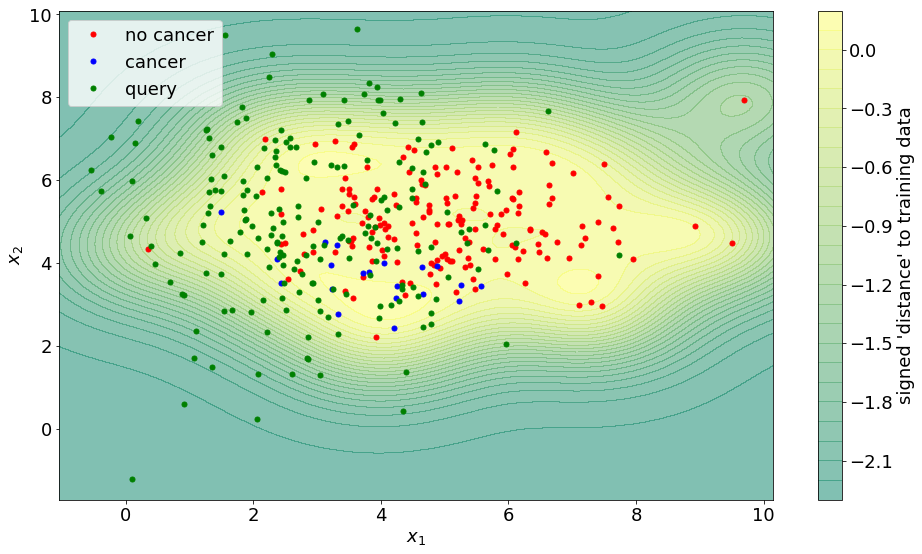

In [63]:
# Make a one class support vector machine, and set 10% training error bound
ocsvm = OneClassSVM(nu=0.1)
ocsvm.fit(Xt)  # Give it all the *training* data we have

# Now plot the support it has learned
def plot_support(clf, x):
    xmin, xmax = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    ymin, ymax = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax.max():.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    dist = clf.decision_function(grid).reshape(xx.shape)
    contour = pl.contourf(xx, yy, dist, 25, cmap="summer", alpha=0.5)
    ax_c = pl.colorbar(contour)
    ax_c.set_label("signed 'distance' to training data")
    #ax_c.set_ticks([0, .25, .5, .75, 1])

pl.figure(figsize=FIGSIZE) 
plot_support(ocsvm, Xall)
plot_data()

Now say we suddenly have access to our query set, we can use this SVM to *also classify* if the new point is in the support of our training data!

In [61]:
# Classify if the newly obtained query data is in our training set! (using the same validation set as before)
z_bar = ocsvm.predict(X_test) > 0
res = res.append(score_result(z_test, z_bar, "One-class SVM"))
display(HTML(res.to_html()))

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Gaussian Process,0.7750,0.200,0.491864,0.789474,0.75
One-class SVM,0.6875,0.475,NaN,0.641509,0.85


This **heavily** relies on your choice of kernel and $\nu$ parameter for the SVM... you may want to err on the side of a more "compact" support:
- shorter length scales
- higher $\nu$
so again, use with caution... but maybe it is better than nothing?

# Correcting for covariate shift
So, before we do this, we have to establish that
- Not predicting
- Getting more training data in the query data region
are not possible options -- because these will be better than the next suggestion!